In [1]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

In [2]:
# General imports
import os
import pickle
from scipy import stats
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Utility imports
from utils.losses import *
from utils.plotting import *
from utils.training import *

np.random.seed(666) # Need to do more to ensure data is the same across runs.
h = 10              # Plots have dimension (h, h)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-08-04 12:40:46.977423: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-08-04 12:40:47.001995: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:c1:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-08-04 12:40:47.002237: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-04 12:40:47.003646: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-04 12:40:47.005366: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-08-04 12:40:47.005582: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2

# Naive Implementation

In [4]:
num = 3
reps = 100
Ns = 10**np.arange(2, 8)

mu = 0.1
bkgd = stats.norm(-mu, 1)
sgnl = stats.norm(mu, 1)

mae = make_mae(bkgd, sgnl)
lr = make_lr(bkgd, sgnl)

# Model parameters
bce_params = {'loss':bce}
mse_params = {'loss':mse}
mlc_params = {'loss':mlc, 'output':'relu'}
sqr_params = {'loss':sqr, 'output':'relu'}

filestr = 'models/univariate/loss_comp/set_{}/'.format(num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
mse_filestr = filestr + 'mse/model_{}_{}.h5'
mlc_filestr = filestr + 'mlc/model_{}_{}.h5'
sqr_filestr = filestr + 'sqr/model_{}_{}.h5'

## Likelihood Ratios

### Process

### Plot

In [5]:
xs = np.load(filestr + 'xs.npy')
bce_preds = np.load(filestr + 'bce_preds.npy')
mse_preds = np.load(filestr + 'mse_preds.npy')
mlc_preds = np.load(filestr + 'mlc_preds.npy')
sqr_preds = np.load(filestr + 'sqr_preds.npy')

In [6]:
bce_lr = avg_lr(bce_preds)
mse_lr = avg_lr(mse_preds)
mlc_lr = avg_lr(mlc_preds)
sqr_lr = avg_lr(sqr_preds)

bce_lrr = avg_lrr(lr, bce_preds, xs)
mse_lrr = avg_lrr(lr, mse_preds, xs)
mlc_lrr = avg_lrr(lr, mlc_preds, xs)
sqr_lrr = avg_lrr(lr, sqr_preds, xs)

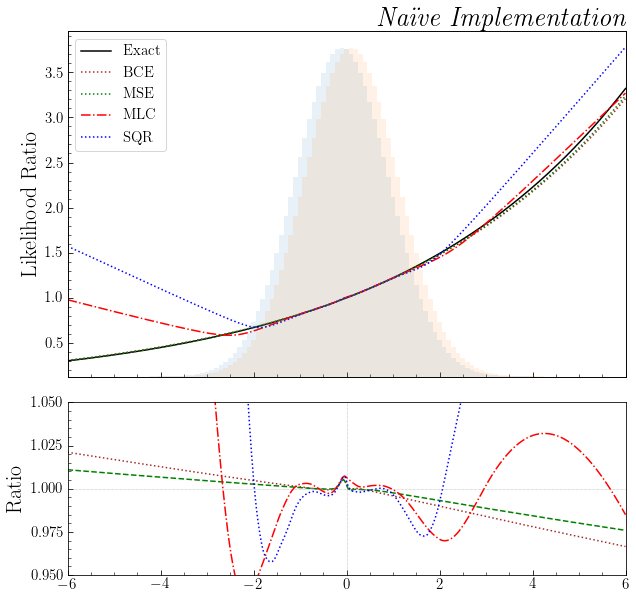

In [7]:
fig, axs = plt.subplots(2, 1,
                        figsize = (h, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

# Plot likelihood ratios
axs[0].plot(xs, lr(xs), c = 'k', label = 'Exact')
axs[0].plot(xs, bce_lr, c = 'brown', ls = ':', label = 'BCE')
axs[0].plot(xs, mse_lr, c = 'green', ls = ':', label = 'MSE')
axs[0].plot(xs, mlc_lr, c = 'red', ls = '-.', label = 'MLC')
axs[0].plot(xs, sqr_lr, c = 'blue', ls = ':', label = 'SQR')
axs[0].set_xlim(-6, 6)
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('Likelihood Ratio')

# Plot exact histograms
hist_ax = axs[0].twinx()
bins = np.linspace(-6.05, 6.05, 122)
weights = bkgd.cdf(bins)[1:] - bkgd.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1)
weights = sgnl.cdf(bins)[1:] - sgnl.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1);
hist_ax.set_yticks([]);

# Plot likelihood ratio ratios
axs[1].plot(xs, bce_lrr, c = 'brown', ls = ':')
axs[1].plot(xs, mse_lrr, c = 'green', ls = '--')
axs[1].plot(xs, mlc_lrr, c = 'red', ls = '-.')
axs[1].plot(xs, sqr_lrr, c = 'blue', ls = ':')
axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.title(r'\it Na\"ive Implementation', loc = 'right')
plt.savefig('plots/paper/naive_fit.png', 
            dpi = 300,
            transparent = True,
            bbox_inches = 'tight')

## MAEs

### Process

### Plot

In [8]:
bce_avg = np.load(filestr + 'bce_avg.npy')
mse_avg = np.load(filestr + 'mse_avg.npy')
mlc_avg = np.load(filestr + 'mlc_avg.npy')
sqr_avg = np.load(filestr + 'sqr_avg.npy')

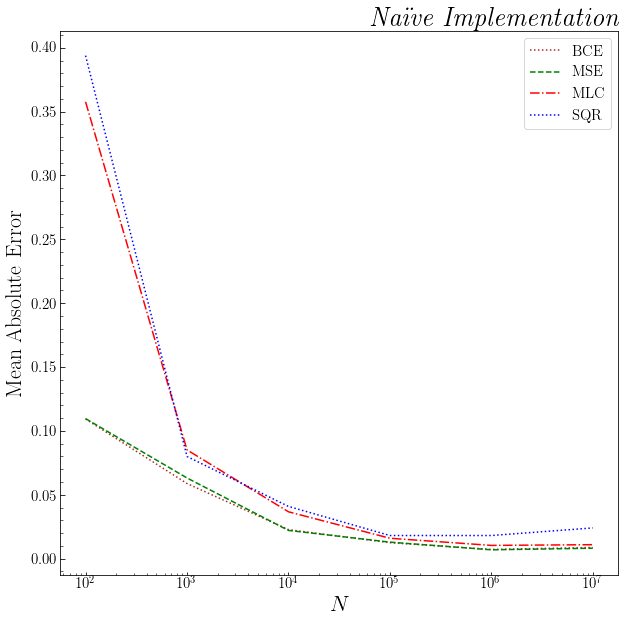

In [9]:
# Plot MAEs
plt.figure(figsize = (h, h))

plt.plot(Ns, bce_avg, c='brown', ls=':', label='BCE')
plt.plot(Ns, mse_avg, c='green', ls='--', label='MSE')
plt.plot(Ns, mlc_avg, c='red', ls='-.', label='MLC')
plt.plot(Ns, sqr_avg, c='blue', ls=':', label='SQR')
plt.legend()

plt.minorticks_on()
plt.tick_params(axis = 'y', which = 'minor', length = 3)
plt.tick_params(axis = 'y', which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.xscale("log", base=10)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$N$')

plt.title(r'\it Na\"ive Implementation', loc="right");
plt.savefig('plots/paper/naive_sizes.png',
            transparent = True,
            dpi=300, 
            bbox_inches='tight')

# $C$ Parametrization

## BCE $C$ Parametrization

In [10]:
# Experiment parameters
num = 2
reps = 100

# Model parameters
params_1 = {'loss':bce}
params_2 = {'loss':tanh_bce, 'output': 'linear'}
params_3 = {'loss':atan_bce, 'output': 'linear'}

filestr = 'models/univariate/bce_c_param/set_{}/'.format(num)
filestr_1 = filestr + 'linear/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'atan/model_{}.h5'

m = np.load(filestr + 'm.npy')
s = np.load(filestr + 's.npy')

N = 10**6
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl)

### Process

### Likelihood Ratios

In [11]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [12]:
lr_1 = avg_lr(preds_1)
lr_2 = avg_lr(preds_2)
lr_3 = avg_lr(preds_3)

lrr_1 = avg_lrr(lr, preds_1, xs)
lrr_2 = avg_lrr(lr, preds_2, xs)
lrr_3 = avg_lrr(lr, preds_3, xs)

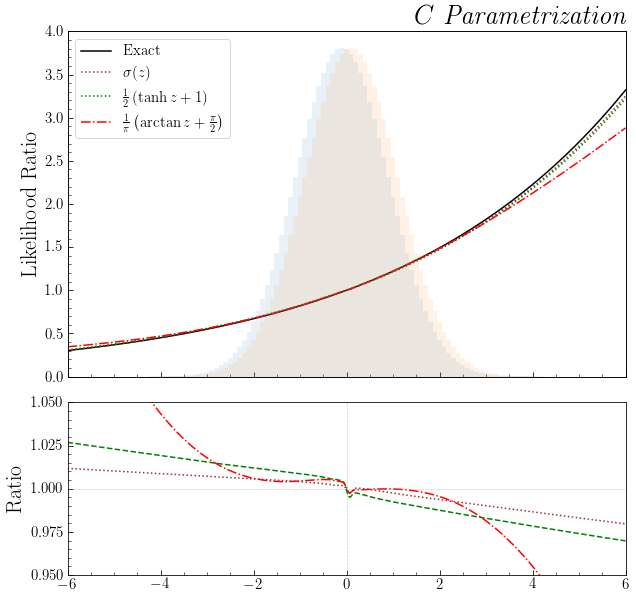

In [13]:
fig, axs = plt.subplots(2, 1,
                        figsize = (h, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

# Plot likelihood ratios
axs[0].plot(xs, lr(xs), c = 'k', label = 'Exact')
axs[0].plot(xs, lr_1, c = 'brown', ls = ':', label = r'$\sigma(z)$')
axs[0].plot(xs, lr_2, c = 'green', ls = ':', label = r'$\frac{1}{2}\left(\tanh{z} + 1\right)$')
axs[0].plot(xs, lr_3, c = 'red', ls = '-.', label = r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$')
axs[0].set_xlim(-6, 6)
axs[0].set_ylim(0, 4)
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('Likelihood Ratio')
axs[0].set_title(r'\it $C$ Parametrization', loc = 'right')

# Plot exact histograms
hist_ax = axs[0].twinx()
bins = np.linspace(-6.05, 6.05, 122)
weights = bkgd.cdf(bins)[1:] - bkgd.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1)
weights = sgnl.cdf(bins)[1:] - sgnl.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1);
hist_ax.set_yticks([]);

# Plot likelihood ratio ratios
axs[1].plot(xs, lrr_1, c = 'brown', ls = ':')
axs[1].plot(xs, lrr_2, c = 'green', ls = '--')
axs[1].plot(xs, lrr_3, c = 'red', ls = '-.')
axs[1].axhline(1, ls=":", color="grey", lw=0.5)
axs[1].axvline(0, ls=":", color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)

plt.savefig('plots/paper/bce_c.png', 
            dpi = 300,
            transparent = True,
            bbox_inches = 'tight')

### MAEs

In [14]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

0.006326569852379711 0.010670640665592621 0.007373237817989721


## MSE $C$ Parametrization

In [15]:
# Experiment parameters
num = 2
reps = 100

# Model parameters
params_1 = {'loss':mse}
params_2 = {'loss':tanh_mse, 'output': 'linear'}
params_3 = {'loss':atan_mse, 'output': 'linear'}

filestr = 'models/univariate/mse_c_param/set_{}/'.format(num)
filestr_1 = filestr + 'linear/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'atan/model_{}.h5'

m = np.load(filestr + 'm.npy')
s = np.load(filestr + 's.npy')

N = 10**6
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl)

### Process

### Likelihood Ratios

In [16]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [17]:
lr_1 = avg_lr(preds_1)
lr_2 = avg_lr(preds_2)
lr_3 = avg_lr(preds_3)

lrr_1 = avg_lrr(lr, preds_1, xs)
lrr_2 = avg_lrr(lr, preds_2, xs)
lrr_3 = avg_lrr(lr, preds_3, xs)

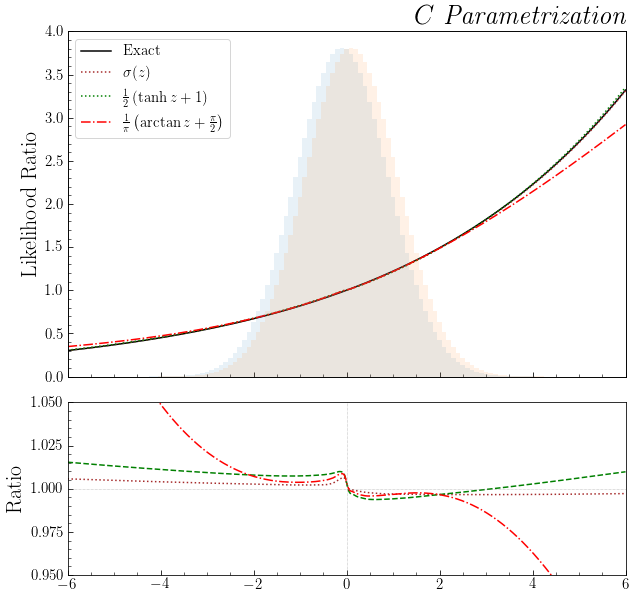

In [18]:
fig, axs = plt.subplots(2, 1,
                        figsize = (h, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

# Plot likelihood ratios
axs[0].plot(xs, lr(xs), c = 'k', label = 'Exact')
axs[0].plot(xs, lr_1, c = 'brown', ls = ':', label = r'$\sigma(z)$')
axs[0].plot(xs, lr_2, c = 'green', ls = ':', label = r'$\frac{1}{2}\left(\tanh{z} + 1\right)$')
axs[0].plot(xs, lr_3, c = 'red', ls = '-.', label = r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$')
axs[0].set_xlim(-6, 6)
axs[0].set_ylim(0, 4)
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('Likelihood Ratio')
axs[0].set_title(r'\it $C$ Parametrization', loc = 'right')

# Plot exact histograms
hist_ax = axs[0].twinx()
bins = np.linspace(-6.05, 6.05, 122)
weights = bkgd.cdf(bins)[1:] - bkgd.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1)
weights = sgnl.cdf(bins)[1:] - sgnl.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1);
hist_ax.set_yticks([]);

# Plot likelihood ratio ratios
axs[1].plot(xs, lrr_1, c = 'brown', ls = ':')
axs[1].plot(xs, lrr_2, c = 'green', ls = '--')
axs[1].plot(xs, lrr_3, c = 'red', ls = '-.')
axs[1].axhline(1, ls=":", color="grey", lw=0.5)
axs[1].axvline(0, ls=":", color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)

plt.savefig('plots/paper/mse_c.png', 
            dpi = 300,
            transparent = True,
            bbox_inches = 'tight')

### MAEs

In [19]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

0.006487791567832075 0.011441699888795242 0.008235159338260982


## MLC $C$ Parametrization

In [20]:
# Experiment parameters
num = 5
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'output': 'linear'}

filestr = 'models/univariate/mlc_c_param/set_{}/'.format(num)
filestr_1 = filestr + 'linear/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponl/model_{}.h5'

mlc_m = np.load(filestr + 'm.npy')
mlc_s = np.load(filestr + 's.npy')

N = 10**6
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl)

### Process

### Likelihood Ratios

In [21]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [22]:
lr_1 = avg_lr(preds_1)
lr_2 = avg_lr(preds_2)
lr_3 = avg_lr(preds_3)

lrr_1 = avg_lrr(lr, preds_1, xs)
lrr_2 = avg_lrr(lr, preds_2, xs)
lrr_3 = avg_lrr(lr, preds_3, xs)

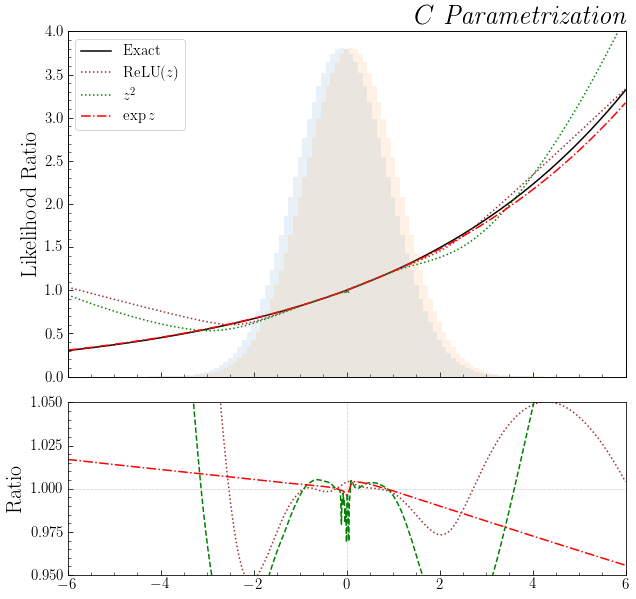

In [23]:
fig, axs = plt.subplots(2, 1,
                        figsize = (h, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

# Plot likelihood ratios
axs[0].plot(xs, lr(xs), c = 'k', label = 'Exact')
axs[0].plot(xs, lr_1, c = 'brown', ls = ':', label = r'$\text{ReLU}(z)$')
axs[0].plot(xs, lr_2, c = 'green', ls = ':', label = r'$z^2$')
axs[0].plot(xs, lr_3, c = 'red', ls = '-.', label = r'$\exp{z}$')
axs[0].set_xlim(-6, 6)
axs[0].set_ylim(0, 4)
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('Likelihood Ratio')
axs[0].set_title(r'\it $C$ Parametrization', loc = 'right')

# Plot exact histograms
hist_ax = axs[0].twinx()
bins = np.linspace(-6.05, 6.05, 122)
weights = bkgd.cdf(bins)[1:] - bkgd.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1)
weights = sgnl.cdf(bins)[1:] - sgnl.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1);
hist_ax.set_yticks([]);

# Plot likelihood ratio ratios
axs[1].plot(xs, lrr_1, c = 'brown', ls = ':')
axs[1].plot(xs, lrr_2, c = 'green', ls = '--')
axs[1].plot(xs, lrr_3, c = 'red', ls = '-.')
axs[1].axhline(1, ls=":", color="grey", lw=0.5)
axs[1].axvline(0, ls=":", color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)

plt.savefig('plots/paper/mlc_c.png', 
            dpi = 300,
            transparent = True,
            bbox_inches = 'tight')

### MAEs

In [24]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

0.010491373754354008 0.02220955158871461 0.0064453856390552875


## SQR $C$ Parametrization

In [25]:
# Experiment parameters
num = 5
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'output': 'linear'}

filestr = 'models/univariate/sqr_c_param/set_{}/'.format(num)
filestr_1 = filestr + 'linear/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponl/model_{}.h5'

mlc_m = np.load(filestr + 'm.npy')
mlc_s = np.load(filestr + 's.npy')

N = 10**6
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl)

### Process

### Likelihood Ratios

In [26]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [27]:
lr_1 = avg_lr(preds_1)
lr_2 = avg_lr(preds_2)
lr_3 = avg_lr(preds_3)

lrr_1 = avg_lrr(lr, preds_1, xs)
lrr_2 = avg_lrr(lr, preds_2, xs)
lrr_3 = avg_lrr(lr, preds_3, xs)

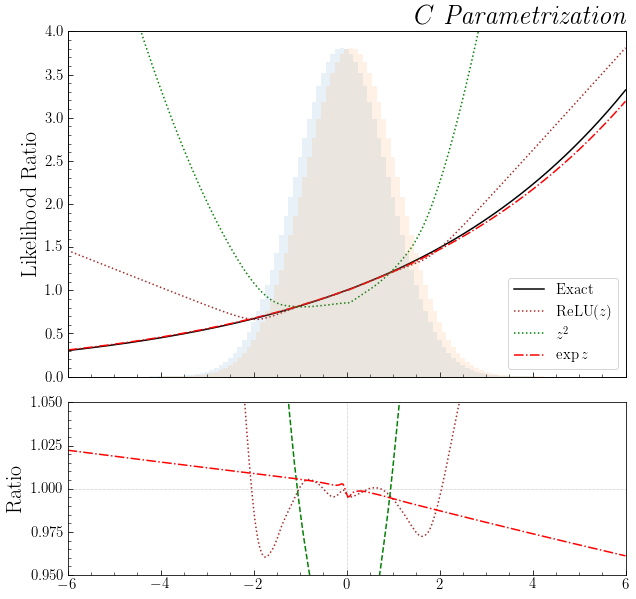

In [28]:
fig, axs = plt.subplots(2, 1,
                        figsize = (h, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

# Plot likelihood ratios
axs[0].plot(xs, lr(xs), c = 'k', label = 'Exact')
axs[0].plot(xs, lr_1, c = 'brown', ls = ':', label = r'$\text{ReLU}(z)$')
axs[0].plot(xs, lr_2, c = 'green', ls = ':', label = r'$z^2$')
axs[0].plot(xs, lr_3, c = 'red', ls = '-.', label = r'$\exp{z}$')
axs[0].set_xlim(-6, 6)
axs[0].set_ylim(0, 4)
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('Likelihood Ratio')
axs[0].set_title(r'\it $C$ Parametrization', loc = 'right')

# Plot exact histograms
hist_ax = axs[0].twinx()
bins = np.linspace(-6.05, 6.05, 122)
weights = bkgd.cdf(bins)[1:] - bkgd.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1)
weights = sgnl.cdf(bins)[1:] - sgnl.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1);
hist_ax.set_yticks([]);

# Plot likelihood ratio ratios
axs[1].plot(xs, lrr_1, c = 'brown', ls = ':')
axs[1].plot(xs, lrr_2, c = 'green', ls = '--')
axs[1].plot(xs, lrr_3, c = 'red', ls = '-.')
axs[1].axhline(1, ls=":", color="grey", lw=0.5)
axs[1].axvline(0, ls=":", color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)

plt.savefig('plots/paper/sqr_c.png', 
            dpi = 300,
            transparent = True,
            bbox_inches = 'tight')

### MAEs


In [29]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

0.01734030661459949 0.18564002481547692 0.007578177331963234


# $A$/$B$ Parametrization

## SQR $A/B$ Parametrization

In [30]:
num = 2
reps = 20

filestr = 'models/univariate/sqr_ab_param/set_{}/'.format(num)
lin_filestr = filestr + 'linear/model_{}_{}.h5'
exp_filestr = filestr + 'exp/model_{}_{}.h5'

m = np.load(filestr + 'm.npy')
s = np.load(filestr + 's.npy')

N = 10**6
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

### Process

### MAEs

In [31]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

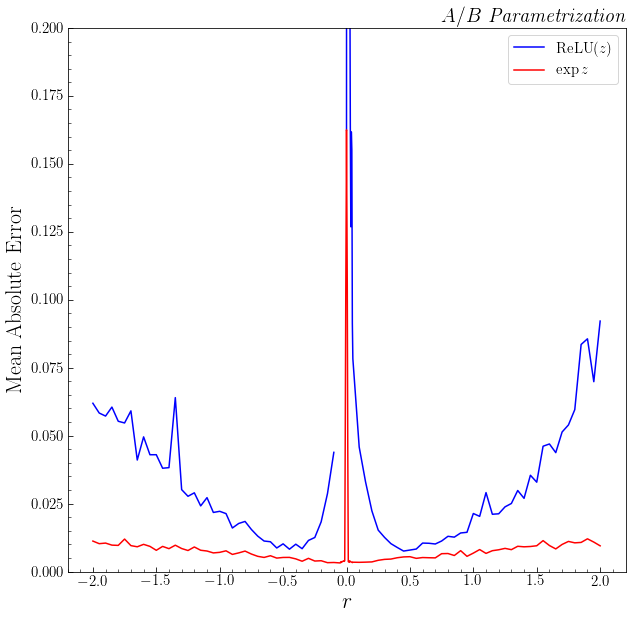

In [32]:
plt.figure(figsize = (h, h))

plt.plot(rs, lin_avgs, c='blue', label=r'$\text{ReLU}(z)$')
plt.plot(rs, exp_avgs, c='red', label=r'$\exp{z}$')
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
plt.ylim(0, 0.2)

plt.title(r"\it $A/B$ Parametrization",loc="right",fontsize=20);
plt.savefig('plots/paper/sqr_ab.png', 
            dpi=300, 
            bbox_inches='tight')

## MSE $A/B$ Parametrization

In [33]:
num = 0         
reps = 20
N = 10**6
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(0.1, 1)

filestr = 'models/univariate/mse_ab_param/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl)

m = np.load(filestr + 'm.npy')
s = np.load(filestr + 's.npy')

ps = np.round(np.linspace(-2, 2, 101), 2)

### Process

### MAEs

In [34]:
avgs = np.load(filestr + 'avgs.npy')

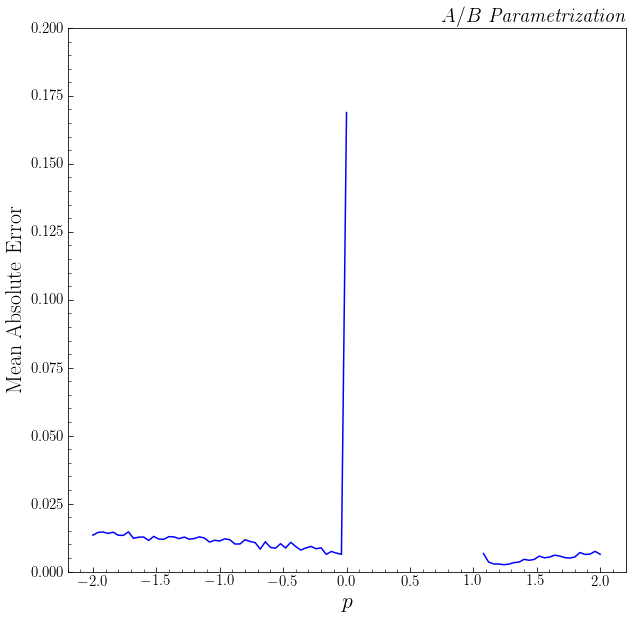

In [35]:
plt.figure(figsize = (h, h))

plt.plot(ps, avgs, c='blue')

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
plt.ylim(0, 0.2)

plt.title(r"\it $A/B$ Parametrization",loc="right",fontsize=20);
plt.savefig('plots/paper/mse_ab.png', 
            dpi=300, 
            bbox_inches='tight')

# Optimized Implementation

In [36]:
num = 4
reps = 100
Ns = 10**np.arange(2, 8)

mu = 0.1
bkgd = stats.norm(-mu, 1)
sgnl = stats.norm(mu, 1)

mae = make_mae(bkgd, sgnl)
lr = make_lr(bkgd, sgnl)

# Model parameters
bce_params = {'loss':bce}
mse_params = {'loss':get_mse(1.24)}
mlc_params = {'loss':exp_mlc, 'output':'linear'}
sqr_params = {'loss':get_exp_sqr(-0.05), 'output':'linear'}

filestr = 'models/univariate/loss_comp/set_{}/'.format(num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
mse_filestr = filestr + 'mse/model_{}_{}.h5'
mlc_filestr = filestr + 'mlc/model_{}_{}.h5'
sqr_filestr = filestr + 'sqr/model_{}_{}.h5'

## Likelihood Ratios

### Process

### Plot

In [37]:
xs = np.load(filestr + 'xs.npy')
bce_preds = np.load(filestr + 'bce_preds.npy')
mse_preds = np.load(filestr + 'mse_preds.npy')
mlc_preds = np.load(filestr + 'mlc_preds.npy')
sqr_preds = np.load(filestr + 'sqr_preds.npy')

In [38]:
bce_lr = avg_lr(bce_preds)
mse_lr = avg_lr(mse_preds)
mlc_lr = avg_lr(mlc_preds)
sqr_lr = avg_lr(sqr_preds)

bce_lrr = avg_lrr(lr, bce_preds, xs)
mse_lrr = avg_lrr(lr, mse_preds, xs)
mlc_lrr = avg_lrr(lr, mlc_preds, xs)
sqr_lrr = avg_lrr(lr, sqr_preds, xs)

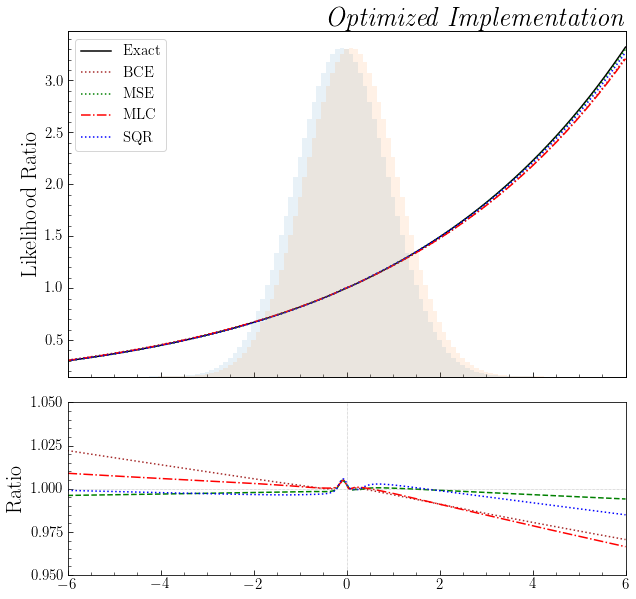

In [39]:
fig, axs = plt.subplots(2, 1,
                        figsize = (h, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

# Plot likelihood ratios
axs[0].plot(xs, lr(xs), c = 'k', label = 'Exact')
axs[0].plot(xs, bce_lr, c = 'brown', ls = ':', label = 'BCE')
axs[0].plot(xs, mse_lr, c = 'green', ls = ':', label = 'MSE')
axs[0].plot(xs, mlc_lr, c = 'red', ls = '-.', label = 'MLC')
axs[0].plot(xs, sqr_lr, c = 'blue', ls = ':', label = 'SQR')
axs[0].set_xlim(-6, 6)
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('Likelihood Ratio')

# Plot exact histograms
hist_ax = axs[0].twinx()
bins = np.linspace(-6.05, 6.05, 122)
weights = bkgd.cdf(bins)[1:] - bkgd.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1)
weights = sgnl.cdf(bins)[1:] - sgnl.cdf(bins[:-1])
plt.hist(bins[:-1], bins = bins, weights = weights, alpha = 0.1);
hist_ax.set_yticks([]);

# Plot likelihood ratio ratios
axs[1].plot(xs, bce_lrr, c = 'brown', ls = ':')
axs[1].plot(xs, mse_lrr, c = 'green', ls = '--')
axs[1].plot(xs, mlc_lrr, c = 'red', ls = '-.')
axs[1].plot(xs, sqr_lrr, c = 'blue', ls = ':')
axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.title(r'\it Optimized Implementation', loc = 'right')
plt.savefig('plots/paper/best_fit.png', 
            dpi = 300,
            transparent = True,
            bbox_inches = 'tight')

## MAEs

### Process

### Plot

In [40]:
bce_avg = np.load(filestr + 'bce_avg.npy')
mse_avg = np.load(filestr + 'mse_avg.npy')
mlc_avg = np.load(filestr + 'mlc_avg.npy')
sqr_avg = np.load(filestr + 'sqr_avg.npy')

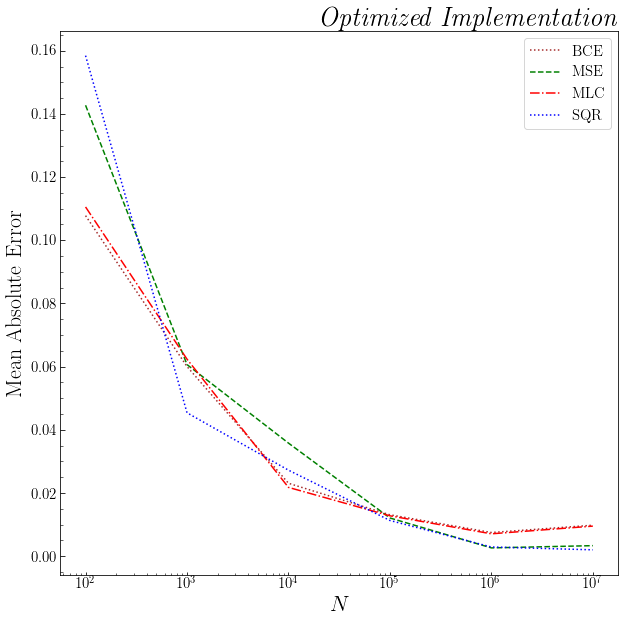

In [41]:
# Plot MAEs
plt.figure(figsize = (h, h))

plt.plot(Ns, bce_avg, c='brown', ls=':', label='BCE')
plt.plot(Ns, mse_avg, c='green', ls='--', label='MSE')
plt.plot(Ns, mlc_avg, c='red', ls='-.', label='MLC')
plt.plot(Ns, sqr_avg, c='blue', ls=':', label='SQR')
plt.legend()

plt.minorticks_on()
plt.tick_params(axis = 'y', which = 'minor', length = 3)
plt.tick_params(axis = 'y', which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.xscale("log", base=10)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$N$')

plt.title(r'\it Optimized Implementation', loc="right");
plt.savefig('plots/paper/best_sizes.png',
            transparent = True,
            dpi=300, 
            bbox_inches='tight')